In [ ]:
# [Nur Colab] Diese Zellen müssen nur auf *Google Colab* ausgeführt werden und installieren Packete und Daten
!wget -q https://raw.githubusercontent.com/KI-Campus/AMALEA/master/requirements.txt && pip install --quiet -r requirements.txt
!wget --quiet "https://github.com/KI-Campus/AMALEA/releases/download/data/data.zip" && unzip -q data.zip

# Künstlicher Ghost-Writer

## Text/Liedtext/Märchen-Generator mit LSTM

In diesem Notebook werden Sie lernen, wie Sie mithilfe von Long Short-Term Memory-Netzwerken Texte generieren können. Die Art des Textes, den das Modell generiert, hängt von den Daten ab, mit denen Sie das Netzwerk trainieren. Wenn Sie als Trainingstext einen Liedtext Ihres Lieblingssängers verwenden, wird das LSTM-Modell lernen, Lieder zu schreiben, die diesem ähnlich sind.

In diesem Notebook werden wir den Text der Grimms Märchen zum Trainieren verwenden. Der Code basiert auf dem Artikel von Jason Brownlee [How to Develop a Word-Level Neural Language Model and Use it to Generate Text](https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/).

Dazu werden wir wie bereits zuvor mit der Datenvorbereitung beginnen, anschließend das LSTM-Modell definieren und es abschließend trainieren und testen.

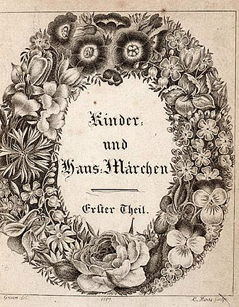
<p style="text-align: center;">
    Abb. 1 - Illustriertes Titelblatt des ersten Bandes der zweiten Auflage von 1819
</p>

### Datenvorbereitung

In diesem Abschnitt des Notebooks wird die Textdatei in den Speicher geladen, bereinigt (Löschen von Satzzeichen und nicht-alphabetischen Begriffen sowie Umwandlung aller Großbuchstaben in Kleinbuchstaben), um den Lernprozess für das LSTM-Netzwerk zu erleichtern. Die Wörter werden anschließend tokenisiert (Umwandlung von Text in Zahlen), da das Modell am Ende mit Zahlen und nicht mit Zeichenketten arbeitet. Die Textzeilen werden außerdem in Sequenzen mit einer festen Länge zusammengefasst, da das Netzwerk über eine feste Anzahl von Eingangsneuronen verfügt.

In [ ]:
# Data preparation
import string

# load doc into memory
def load_doc(filename:str)->str:
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc:str)->list:
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

# save tokens to file, one dialog per line
def save_doc(lines:list, filename:str):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# load document
in_filename = 'data/grimms_en.txt'
doc = load_doc(in_filename)
print(doc[:500])
print("\n")

# clean document
tokens = clean_doc(doc)
print(tokens[:100])
print("\n")
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

# organize into sequences of tokens
length = 12 + 1      # +1 refers to the to-be-forecast word
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

# save sequences to file
out_filename = 'grimms_sequences_len12.txt'
save_doc(sequences, out_filename)

<div class="alert alert-block alert-success">
<b>Frage 6.4.1:</b> Die Textzeilen werden in Sequenzen mit einer festen Länge zusammengefasst, da das Netzwerk über eine feste Anzahl von Eingangsneuronen verfügt. Welche Länge für die Eingangssequenzen wurde in diesem Code verwendet?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


<div class="alert alert-block alert-success">
<b>Frage 6.4.2:</b> Warum ist die Anzahl an „Total Tokens“ größer als an „Unique Tokens“?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


### Strukturdefinition und Modellierung von LSTM-Netzen

Im folgenden wird die Struktur des LSTM-Netzes definiert und das Training durchgeführt. Das Modell wird dabei so aufgebaut, dass es basierend auf einer gegebenen Sequenz ein Wort nach dem anderen vorhersagen kann. Wenn die Sequenz zum Beispiel "Ich komme aus Spanien, meine Muttersprache ist" lautet, sollte das LSTM-Modell "Spanisch" vorhersagen (natürlich nur, wenn es die Abhängigkeiten zwischen Spanien und Spanisch aus dem Trainingsdatensatz lernen konnte).

Um das LSTM-Modell zu definieren, verwenden wir die Keras Bibliothek als Wrapper von Tensorflow. Wenn Sie die GPU nutzen wollen, müssen Sie in der conda-Umgebung tensorflow-gpu installieren. Die Tensorflow Imports bleiben dabei aber unverändert (so wie unten gezeigt).

Bei der Definition des LSTM-Netzwerks wird ein [Embedding Layer](https://www.tensorflow.org/text/guide/word_embeddings) hinzugefügt. Dieser wird für Vektorrepräsentationen von Wörtern verwendet, auch bekannt als "word embeddings", wie im Artikel [Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) von Mikolov et al. beschrieben. Wenn Sie eine sehr gute Erklärung für die Verwendung von Embeddings für die Vektorisierung von Wörtern suchen, empfehlen wir Ihnen, den Artikel [Vector Representations of Words](https://www.tensorflow.org/tutorials/representation/word2vec) von der TensorFlow-Website zu lesen.

Spielen Sie gerne mit den Hyperparametern des Modells (Anzahl der Schichten, Neuronen, Optimierer, Batchsize, Epochen, usw.), um bessere Ergebnisse zu erhalten. Sie können auch mit einer Hyperparameter-Optimierungsbibliothek experimentieren, anstatt die Werte von Hand zu ändern. Dazu können Sie die Bibliothek [GpyOpt](https://github.com/SheffieldML/GPyOpt) für Bayes'sche Optimierung oder [HyperOpt](http://hyperopt.github.io/hyperopt/), die Randomsearch und Tree of Parzen Estimators Algorithmen bereitstellt, verwenden. Um mehr über Hyperparameter-Optimierungsmethoden zu erfahren, lesen Sie diese Artikel:
- [Hyperparameter-Optimierung in Machine Learning-Modellen](https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models) von Sayak Paul.
- [Automated Machine Learning Hyperparameter Tuning in Python](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a) von Will Koehrsen.

In [ ]:
# Libraries upload
from numpy import array
from pickle import dump
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python import keras
#from keras.optimizers import Adam
#from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Führen Sie die nachfolgende Zelle aus, um den Tokenizer zu fitten und die Sequezen zu laden.

In [ ]:
# load doc into memory
def load_doc(filename:str):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load
in_filename = 'grimms_sequences_len12.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

<div class="alert alert-block alert-success">
<b>Aufgabe 6.4.3:</b> Teilen Sie die oben geladenen Eingangs- und Ausgangsdaten in einen Trainings- und Testdatensatz auf (80% zu 20%, zufällig aufgeteilt). Verwenden Sie dafür die Funktion train_test_split() von sklearn und legen Sie die so erhaltenen beiden Splits in den Variablen <code>X_train, X_test, y_train, y_test</code> ab.
</div>

In [ ]:
# train test split
# STUDENT CODE HERE

# STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Frage 6.4.4:</b> Wie werden die „Word Embeddings“ für ein LSTM implementiert?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


<div class="alert alert-block alert-success">
<b>Aufgabe 6.4.5:</b> Fügen Sie dem im Nachfolgenden definierten Sequential Modell zwei versteckte Schichten hinzu. Die erste soll eine LSTM-Schicht mit 512 Zellen und die zweite eine Dense-Schicht mit 512 Neuronen sein. Verwenden Sie für den Dense-Layer die ReLU-Aktivierungsfunktion.
</div>

In [ ]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 150, input_length=seq_length))

# STUDENT CODE HERE

# STUDENT CODE until HERE

model.add(Dense(vocab_size, activation='softmax'))

print(model.summary())
# compile model
adam_opt = Adam(clipvalue=1)
model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])
# fit model
model.fit(X_train, y_train, batch_size=64, epochs=9,validation_data=(X_test,y_test),callbacks=EarlyStopping(monitor='val_loss', patience=2))

# save the model to file
model.save('model_grimms_150epochs.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer_grimms_150epochs.pkl', 'wb'))

<div class="alert alert-block alert-success">
<b>Frage 6.4.6:</b> Warum wird die Softmax-Aktivierungsfunktion in der letzten Schicht des Sequential-Modells (die Dense-Layer) verwendet? Also <code>model.add(Dense(vocab_size, activation='softmax'))</code>?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>


### Modelltest

Nach der Modellerstellung können wir das LSTM-Netzwerk testen, indem wir neue Grimms Märchen Texte generieren. Dazu wird eine Sequenz in das bereits trainierte Modell eingefügt, als Seed. Das Modell wird das wahrscheinlichste nächste Wort für die Sequenz generieren. Das vorhergesagte Wort wird dabei an den ursprünglichen Satz angehängt und erneut als Modelleingabe verwendet, um ein weiteres Wort vorherzusagen. Dieser Vorgang wird iterativ durchgeführt, bis *n_Wörter* generiert sind.

In [ ]:
#  code for generating text from the learned-language model is listed below
from random import randint
from pickle import load
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import numpy as np

# load doc into memory
def load_doc(filename:str):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        prob_predictions = model.predict(encoded, verbose=0)[0]
        yhat = np.argmax(model.predict(encoded, verbose=0), axis=-1)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

# load cleaned text sequences
in_filename = 'grimms_sequences_len12.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1

# load the model
model = load_model('model_grimms_150epochs.h5')

# load the tokenizer
tokenizer = load(open('tokenizer_grimms_150epochs.pkl', 'rb'))

# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

Wie Sie vielleicht bereits durch die Textgenerierung mit unterschiedlichen Seed Texten bemerkt haben, wiederholt sich der durch das LSTM Modell generierte Text häufig (Endlosschleife). Das liegt daran, dass wir in der `generate_seq()` Funktion mit `yhat = np.argmax(model.predict(encoded, verbose=0), axis=-1)` immer nur das Wort mit der höchsten Vorhersage verwenden. Dieses Problem können wir umgehen, indem wir mit der Numpy `random.choice` Funktion zusätzlich ein bisschen Zufall in die Auswahl des nächsten Wortes hinzufügen.

<div class="alert alert-block alert-success">
    <b>Aufgabe 6.4.7:</b> Verwenden Sie im Folgenden nun die Numpy <code>random.choice</code> Funktion bei der Auswahl des nächsten Wortes, wobei die vorhergesagte Wahrscheinlichkeit jedes Wortes als Wahrscheinlichkeitsverteilung der random-Funktion verwendet werden soll. Legen Sie, wie schon in der <code>generate_seq()</code> Funktion, dieses Ergebnis (das ist der Index des ausgewählten Worts) in der Variablen <code>yhat</code> ab.
</div>

In [ ]:
# generate a sequence from a language model using ranom.choice
def generate_seq_random(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        prob_predictions = model.predict(encoded, verbose=0)[0]

        # apply random choice
        # STUDENT CODE HERE

        # STUDENT CODE until HERE

        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

# print seed text
print(seed_text + '\n')

# generate new text
generated = generate_seq_random(model, tokenizer, seq_length, seed_text, 50)
print(generated)